In [1]:
import numpy as np
import itertools
from collections import defaultdict
from matplotlib import pyplot as plt
import pickle

from environment import TrafficEnv
from ml_controller import Controller

In [2]:
def make_epsilon_greedy_policy(Q, epsilon, num_actions):
    def policy_fn(observation):
        actions = np.ones(num_actions, dtype=float) * epsilon / num_actions
        best_action = np.argmax(Q[observation])
        actions[best_action] += (1.0 - epsilon)
        return actions
    return policy_fn

In [3]:
def q_learning(Q, env, num_episodes, group_size, disc_factor=0.95, alpha=0.3, epsilon=0.001):
    stats = {'episode_lengths': np.zeros(num_episodes)}
    
    policy = make_epsilon_greedy_policy(Q, epsilon, env.num_actions)
    avg_len = 0
    
    for i_ep  in range(num_episodes):
        # Display episode number every so often
        if (i_ep + 1) % group_size == 0:
            prev_avg = avg_len
            avg_len = sum(stats['episode_lengths'][i_ep - group_size - 1:i_ep - 1]) / group_size
            avg_diff = avg_len - prev_avg
            print("\rEpisode {}/{}, Latest ep len {}, Average change {}".format(
                i_ep + 1, num_episodes, avg_len, avg_diff), end="")
        
        prev_state = tuple(env.reset())
        
        for t in itertools.count():
            action_probs = policy(prev_state)
            action = np.random.choice(np.arange(env.num_actions), p=action_probs)
            reward, done = env.step(action)
            next_state = tuple(env.state)
            
            stats['episode_lengths'][i_ep] = t
            
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + disc_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[prev_state][action]
            Q[prev_state][action] += alpha * td_delta
            
            if done:
                break
            
            prev_state = next_state
    return Q, stats

In [4]:
def dd():
    return np.zeros(6)

In [5]:
max_cars = 10
episode_length = 30000
group_size = 1000

In [6]:
env = TrafficEnv()
controller = Controller(env, max_cars)

# Q maps the state -> (action -> action-value)
Q = defaultdict(dd)

In [26]:
Q, stats = q_learning(Q, controller, episode_length, group_size)

Episode 30000/30000, Latest ep len 156.307, Average change -0.18800000000001662

In [23]:
ep_len = stats['episode_lengths']
avg_ep_len_arr = []
for ep_range in range(0, episode_length, group_size):
    avg_ep_len = sum(ep_len[ep_range:ep_range+group_size]) / group_size
    avg_ep_len_arr.append(avg_ep_len)

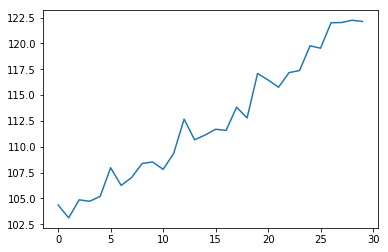

In [24]:
plt.plot(list(range(len(avg_ep_len_arr))), avg_ep_len_arr)

In [25]:
pickle.dump(Q, open('policy.p', 'wb'))

In [11]:
sim_env = TrafficEnv()
sim = Controller(sim_env, max_cars)

In [12]:
total_cars = 0
sim.reset()
for _ in range(100):
    best_action = np.argmax(Q[sim.state])
    print(f'The lane state is {sim.lane_state}')
    print(f'The state is {sim.state}')
    rewards, done  = sim.step(best_action)
    total_cars += sum(sim.lane_state)
    print(f'The action returns are {list(Q[sim.state])}')
    print(f'The action taken was {best_action}')
    print()
    if done:
        break

print('The model did not last for the full simulation')
print(f'The model survived for {_} seconds')
avg_cars = total_cars/_
print(f'Average cars during runtime: {avg_cars}')

The lane state is (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
The state is (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
The action returns are [-5.026785804476649, -5.081045001553208, -4.821658366178063, -4.964930978551738, -4.954085174812419, -3.901606279309073]
The action taken was 5

The lane state is (0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0)
The state is (0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 5.0)
The action returns are [-4.704609018835177, -4.477606492348695, -3.8565468513219687, -4.716920340134989, -4.462952306413799, -4.6406276136683]
The action taken was 5

The lane state is (1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0)
The state is (1.0, 0.0, 2.0, 0.0, 3.0, 0.0, 5.0)
The action returns are [-1.5166499999999998, -1.497808562486395, -1.190270105757894, -0.8999999999999999, -0.6276987978218437, -1.2855]
The action taken was 2

The lane state is (1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0)
The state is (2.0, 0.0, 3.0, 1.0, 4.0, 1.0, 2.0)
The action returns are [-0.4709999999999999, -0.8848799670235, -0.4769605029697105, 0.0, 